In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy.signal as signal
import imageio as io
from tqdm import tqdm
import pickle, re
import cv2
font = cv2.FONT_HERSHEY_SIMPLEX
rgb = (255, 255, 255)

import sys
sys.path.insert(1, '../numphly')
import numphly as nly
import tracker_decoder as tkr_dec
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)


def check_characters(input_string, target_characters):
    return set(target_characters).issubset(set(input_string))

In [2]:
exp_target = 'R72'
gtype_name = ['R72A10xTRPA1','R72A10xW1118','W1118xTRPA1']
sex_name = ['female','male']
h5_dir = '../../FlyBehaviorSet/DLC_tracking/'+exp_target
output_fileloc = '../../FlyBehaviorSet/'
OG_recording_folder= 'original_recording_for_tracking/'+exp_target
converted_folder = 'Converted/R72/'
cropped_recording_folder= 'cropped_recording_for_tracking'  
shared_data_folder = '../Shared_data/'


dir_MCAM = '../DatastreamLine_MCAM_Tracking/'
scorer_floor  = 'DLC_resnet152_floor_topview_12label_1uniqueJan4shuffle1_100000'
# scorer_wall   = 'DLC_resnet152_wall_sideview_7labelsJan1shuffle1_100000'
scorer_wall   = 'DLC_resnet152_wall_sideview_7labelsJan1shuffle1_90000'
# scorer_cross  = 'DLC_resnet152_wall_cross_section_view_8labelFeb19shuffle1_100000'
scorer_cross  = 'DLC_resnet152_wall_cross_section_view_8labelFeb19shuffle1_30000'
pcutoff = 0
frame_n = 126000
frame_rate = 60
frame_n_e = frame_rate*60*30
color_BP = [(0,0,255),(0,255,0),(255,0,0)]
arena_parameters = {
    'well_radius': 8.4,  # mm
    'food_cup_radius': 3.5,  # mm
}
experiments_index  = np.load('experiments_index.npy')
fileloc_set        = np.load('experiments_directory.npy')
num_file = len(fileloc_set)
videofile_set      = np.load('experiments_well_setup.npy')
num_well = len(videofile_set)
experiments_mscore = np.load('experiments_mscore.npy',allow_pickle='TRUE').item()
crop_h = np.load('crop_h.npy')
print(len(fileloc_set))

15


In [3]:
fileloc = fileloc_set[0]
experiment_index = experiments_index[0]
well = 'v_'+experiment_index+'_'+videofile_set[0]
numBP_floor = 12
numBP_wall  = 7
numBP_cross = 8
numUniq = 1

hfile_floor = h5_dir+'/'+well+scorer_floor+'_el_filtered.h5'
Dataframe = pd.read_hdf(os.path.join(hfile_floor))
bodyparts = Dataframe.columns.get_level_values(2)[0:3*numBP_floor];
bodyparts_floor = (bodyparts[0::3])

uniqueID = Dataframe.columns.get_level_values(1)[0:3*numBP_floor*3];
uniqueID = (uniqueID[0::3*numBP_floor])[2]
paint = Dataframe.columns.get_level_values(2)[0:3*numBP_floor*3];
paint = paint[3*numBP_floor*2]

hfile_wall = h5_dir+'/'+well+scorer_wall+'_el_filtered.h5'
Dataframe = pd.read_hdf(os.path.join(hfile_wall))
bodyparts = Dataframe.columns.get_level_values(2)[0:3*numBP_wall];
bodyparts_wall = (bodyparts[0::3])

hfile_cross = h5_dir+'/'+well+scorer_cross+'_el_filtered.h5'
Dataframe = pd.read_hdf(os.path.join(hfile_cross))
bodyparts = Dataframe.columns.get_level_values(2)[0:3*numBP_cross];
bodyparts_cross = (bodyparts[0::3])


animalID = Dataframe.columns.get_level_values(1)[0:3*numBP_cross*3];
animalID = (animalID[0::3*numBP_cross])#[0:2]
n_ID = len(animalID)


numBP_floor = 3
numBP_wall  = 3
numBP_cross = 4
bodyparts_floor = bodyparts_floor[[0,3,4]]
bodyparts_wall  = bodyparts_wall[[1,2,3]]
bodyparts_cross = bodyparts_cross[[0,3,4,7]]


# print(bodyparts_floor1)
print(uniqueID,paint)
print(bodyparts_floor, len(bodyparts_floor))
print(bodyparts_wall, len(bodyparts_wall))
print(bodyparts_cross, len(bodyparts_cross))
# print(animalID)

num_exp = 0
for i in range(num_file):
    experiment = experiments_mscore[fileloc_set[i]]
    sexes        = experiment['sex']
    for j in range(num_well):
        sex = sexes[j]

        if sex != -1:
            num_exp = num_exp+1
            
            
total_events = np.zeros((3,num_exp)).astype(int)
total_events_s = np.zeros((3,num_exp)).astype(int)
genders_status   = -np.ones((num_exp)).astype(int)
genotypes_status = -np.ones((num_exp)).astype(int)
radius = -np.ones((num_exp))
frame_n_e = frame_rate*60*30
ii = 0
for i in range(num_file):
    experiment  = experiments_mscore[fileloc_set[i]]
    sexes       = experiment['sex']
    genotypes   = experiment['genotype']
    events_type = experiment['events type']
    events      = experiment['events']
    circle      = experiment['arena circle']
    start_t     = np.max(experiment['starting_time'])
    well_tracker_select = np.logical_and(np.arange(frame_n)>=start_t,np.arange(frame_n)<start_t+frame_n_e)
    experiment_index = experiments_index[i]
    for j in range(num_well):

        sex = sexes[j]
        genotype = genotypes[j]

        if sex != -1:
#         if sex == 0 and genotype == 2:
            event_ts   = np.array(events[j]).astype(int)
            event_type = np.array(events_type[j]).astype(int)
            well_arena = circle[j]

            n_event = len(event_ts)
            n_event_HB  = sum(event_type==1)
            n_event_UWE = sum(event_type==2)
            n_event_L   = sum(event_type==3)
            
            n_event_HB_s  = sum(well_tracker_select[event_ts[event_type==1]])
            n_event_UWE_s = sum(well_tracker_select[event_ts[event_type==2]])
            n_event_L_s   = sum(well_tracker_select[event_ts[event_type==3]])
            
            total_events[0,ii] = n_event_HB
            total_events[1,ii] = n_event_UWE
            total_events[2,ii] = n_event_L
            total_events_s[0,ii] = n_event_HB_s
            total_events_s[1,ii] = n_event_UWE_s
            total_events_s[2,ii] = n_event_L_s
#             print()
#             if n_event_HB != n_event_HB_s:
#                 print(experiment_index+'_'+videofile_set[j],'HB mis:',n_event_HB, n_event_HB_s)
#             if n_event_UWE != n_event_UWE_s:
#                 print(experiment_index+'_'+videofile_set[j],'UWE mis:',n_event_UWE, n_event_UWE_s)
#             if n_event_L != n_event_L_s:
#                 print(experiment_index+'_'+videofile_set[j],'L mis:',n_event_L, n_event_L_s)

            
            genders_status[ii] = sex
            genotypes_status[ii] = genotype
            radius[ii] = (np.mean(well_arena, axis = 0))[2]
            if sex == 1 and genotype == 0:
                print(experiment_index+'_'+videofile_set[j])
#             print(experiment_index+'_'+videofile_set[j], total_events[0,ii], total_events[1,ii], total_events[2,ii])
            ii += 1
print(ii)



single paint
Index(['head', 'center', 'tail'], dtype='object', name='bodyparts') 3
Index(['head', 'center', 'tail'], dtype='object', name='bodyparts') 3
Index(['top', 'left', 'right', 'down'], dtype='object', name='bodyparts') 4
05_08_24_exp1_D1
05_09_24_exp1_A1
05_09_24_exp1_A2
05_13_24_exp1_A1
05_13_24_exp2_C2
05_13_24_exp3_A1
05_13_24_exp3_D1
07_23_24_exp1_A1
07_23_24_exp1_C1
07_23_24_exp2_A1
07_23_24_exp2_C1
07_24_24_exp1_A1
07_24_24_exp1_A2
86


# body size check

In [4]:
np.set_printoptions(precision=2)

filter_status = '_filtered'
# npz_save = ''
win_size = 1
d_f_ht_tracked   = np.zeros((num_exp,2))
d_f_ht_tracked[:,:] = np.NaN
d_w_ht_tracked   = np.zeros((num_exp,2))
d_w_ht_tracked[:,:] = np.NaN
d_ht_tracked   = np.zeros((num_exp,2))
d_ht_tracked[:,:] = np.NaN


d_f_hc_tracked   = np.zeros((num_exp,2))
d_f_hc_tracked[:,:] = np.NaN
d_w_hc_tracked   = np.zeros((num_exp,2))
d_w_hc_tracked[:,:] = np.NaN
d_hc_tracked   = np.zeros((num_exp,2))
d_hc_tracked[:,:] = np.NaN

d_f_ct_tracked   = np.zeros((num_exp,2))
d_f_ct_tracked[:,:] = np.NaN
d_w_ct_tracked   = np.zeros((num_exp,2))
d_w_ct_tracked[:,:] = np.NaN
d_ct_tracked   = np.zeros((num_exp,2))
d_ct_tracked[:,:] = np.NaN

radius_well = np.zeros((num_file,num_well))
radius_well[:,:] = np.NaN


segment = np.zeros((num_exp,2)).astype('int')
# segment[:,:] = np.NaN

frame_n_e = frame_n
ii = 0
for i in range(num_file):
#     for i in range(5):
    experiment = experiments_mscore[fileloc_set[i]]
    sexes        = experiment['sex']
    genotypes   = experiment['genotype']
    experiment_type = experiment['events type']
    events = experiment['events']
    experiment_index = experiments_index[i]
    start_t = np.max(experiment['starting_time'])
    well_tracker_select = np.logical_and(np.arange(frame_n)>=start_t,np.arange(frame_n)<start_t+frame_n_e)
    well_tracker_select_Nan = ~well_tracker_select
    print('starting_time',start_t, np.sum(well_tracker_select))
    for j in range(num_well):
#         for j in range(1):
        sex = sexes[j]
        genotype = genotypes[j]

        if sex != -1:
            event_ts   = events[j]
            event_type = experiment_type[j]

            circle = crop_h[ii,:]
            radius_well[i,j] = circle[2]
            d_xy = [576/2, 576/2]-circle[0:2]-48

#             parameter_mm2p = (17.4625/circle[2]/2)
            parameter_mm2p = (arena_parameters['well_radius']/circle[2])
            n_event = len(event_ts)
            well = 'v_'+experiment_index+'_'+videofile_set[j]
            

            hfile_wall = h5_dir+'/'+well+scorer_wall+'_el'+filter_status+'.h5'
            my_file_wall = Path(hfile_wall)
            hfile_floor = h5_dir+'/'+well+scorer_floor+'_el'+filter_status+'.h5'
            my_file_floor = Path(hfile_floor)
            hfile_cross = h5_dir+'/'+well+scorer_cross+'_el'+filter_status+'.h5'
            my_file_cross = Path(hfile_cross)

            wall_floor = my_file_wall.is_file() and my_file_floor.is_file()
            wall_floor_cross = wall_floor and my_file_cross.is_file()
            if wall_floor_cross:
                
                Dataframe_floor = pd.read_hdf(os.path.join(hfile_floor))
                Dataframe_wall  = pd.read_hdf(os.path.join(hfile_wall))
                Dataframe_cross = pd.read_hdf(os.path.join(hfile_cross))
                
                loc_floor, conf_floor = nly.read_loc(Dataframe_floor, scorer_floor, animalID, bodyparts_floor)
                loc_wall,  conf_wall  = nly.read_loc(Dataframe_wall,  scorer_wall,  animalID, bodyparts_wall)
                loc_cross, conf_cross = nly.read_loc(Dataframe_cross, scorer_cross, animalID, bodyparts_cross)
                
                thr_cf = 1
                fly_tracker_f = nly.tracking_analysis_or_cf(loc_floor,conf_floor,thr_cf)
                fly_tracker_f_n = np.zeros((2,numBP_floor,2,frame_n))==1
                fly_tracker_f_n[:,:,0,:] = ~fly_tracker_f
                fly_tracker_f_n[:,:,1,:] = ~fly_tracker_f
                loc_floor[fly_tracker_f_n] = np.NaN
                loc_floor[:,:,:,well_tracker_select_Nan] = np.NaN

                    
                fly_tracker_c = nly.tracking_analysis_or_cf(loc_cross,conf_cross,thr_cf)
                fly_tracker_c_n = np.zeros((2,4,2,frame_n))==1
                fly_tracker_c_n[:,:,0,:] = ~fly_tracker_c
                fly_tracker_c_n[:,:,1,:] = ~fly_tracker_c
                loc_cross[fly_tracker_c_n]  = np.NaN
                loc_cross[:,:,:,well_tracker_select_Nan] = np.NaN
                loc_temp_cross          = np.zeros((2,1,2,frame_n))
                loc_temp_cross[:,0,:,:] = np.nanmean(loc_cross, axis=1)
                conf_temp_cross = np.zeros((2,1,frame_n))
                conf_temp_cross[:,0,:] = np.mean(conf_cross, axis=1)
                
                fly_tracker_cross = np.sum(fly_tracker_c,axis=1) ==4
                fly_tracker_w_n_c = np.zeros((2,numBP_wall,2,frame_n))==1
                for i_bp in range(numBP_wall):
                    fly_tracker_w_n_c[:,i_bp,0,:] = fly_tracker_cross
                    fly_tracker_w_n_c[:,i_bp,1,:] = fly_tracker_cross
                    
                fly_tracker_w = nly.tracking_analysis_or_cf(loc_wall, conf_wall,thr_cf)
                fly_tracker_w_n = np.zeros((2,numBP_wall,2,frame_n))==1
                fly_tracker_w_n[:,:,0,:] = ~fly_tracker_w
                fly_tracker_w_n[:,:,1,:] = ~fly_tracker_w
                
                
                loc_wall[fly_tracker_w_n]   = np.NaN
                loc_wall[fly_tracker_w_n_c] = np.NaN
                loc_wall[:,:,:,well_tracker_select_Nan]   = np.NaN


                loc_m = np.mean(loc_floor, axis=1)
                

                # fly pair average distance
                d_f1f2   = np.sqrt(np.sum(np.square(np.diff(loc_m,axis=0)),axis=1))

                l_size_f = 0
                l_size_w = 0

                thr_center = 6/parameter_mm2p
                thr_space  = 1/parameter_mm2p
#                 print(thr_center, 7/parameter_mm2p_2)
#                 print(thr_space,  1/parameter_mm2p_2)
                thr_l_size = 60
                mode = 'top'
                d_f_ht_tracked[ii,0], d_f_ht_tracked[ii,1], d_f_hc_tracked[ii,0], d_f_hc_tracked[ii,1], d_f_ct_tracked[ii,0], d_f_ct_tracked[ii,1], start_size, l_size_f = tkr_dec.bodylength(
                    loc_floor, thr_center, thr_space, mode, parameter_mm2p, thr_l_size)

                if l_size_f == 0:
                    
                    mode = 'side'
                    d_w_ht_tracked[ii,0], d_w_ht_tracked[ii,1], d_w_hc_tracked[ii,0], d_w_hc_tracked[ii,1], d_w_ct_tracked[ii,0], d_w_ct_tracked[ii,1],start_size, l_size_w = tkr_dec.bodylength(
                        loc_wall, thr_center, thr_space, mode, parameter_mm2p, thr_l_size)
                    segment[ii,0] = l_size_w
                    segment[ii,1] = 1
                    d_ht_tracked[ii,:] = d_w_ht_tracked[ii,:]
                    d_hc_tracked[ii,:] = d_w_hc_tracked[ii,:]
                    d_ct_tracked[ii,:] = d_w_ct_tracked[ii,:]
                    print(well, sex, l_size_f, '             ',l_size_w)
                else:
                    segment[ii,0] = l_size_f
                    segment[ii,1] = 0
                    d_ht_tracked[ii,:] = d_f_ht_tracked[ii,:]
                    d_hc_tracked[ii,:] = d_f_hc_tracked[ii,:]
                    d_ct_tracked[ii,:] = d_f_ct_tracked[ii,:]
                if sex == 0 and (d_ht_tracked[ii,0]>3.0 or d_ht_tracked[ii,1]>3.0):
                    print(well, d_ht_tracked[ii,:], parameter_mm2p, parameter_mm2p_2, circle[2])
                if sex == 0 and (d_ht_tracked[ii,0]<2 or d_ht_tracked[ii,1]<2):
                    print(well, d_ht_tracked[ii,:], parameter_mm2p, parameter_mm2p_2, circle[2])
#                 if d_w_ht_tracked[ii,0] <2 or d_w_ht_tracked[ii,1] <2 or d_f_ht_tracked[ii,0] <2 or d_f_ht_tracked[ii,1] <2:
#                     print(start_size, segment[ii,0])
#                     video = output_fileloc +converted_folder+fileloc_set[i]+'well_'+videofile_set[j]+'_ts.mp4'
#                     cap = cv2.VideoCapture(video)
#                     for idx_i in [start_size,
#                                   start_size+1,
#                                   start_size+int(segment[ii,0]/2),
#                                   start_size+segment[ii,0]-1,
#                                   start_size+segment[ii,0]
#                                  ]:
#                         loc_f_i = loc_floor[:,:,:,idx_i]
#                         loc_w_i = loc_wall[:,:,:,idx_i]
#                         loc_c_i = loc_temp_cross[:,:,:,idx_i]

#                         cf_f_i = conf_floor[:,:,idx_i]
#                         cf_w_i = conf_wall [:,:,idx_i]
#                         cf_c_i = conf_temp_cross[:,0,idx_i]
#                         image = (output_fileloc + cropped_recording_folder +'/R72/Test/'+well+'_'+format(idx_i,'06d')+'_'+str(segment[ii,0]))
#                         tkr_dec.save_image_fwc(cap, loc_f_i, loc_w_i, loc_c_i, 
#                                              cf_f_i,  cf_w_i,  cf_c_i, 
#                                        video, idx_i, image, d_xy, bodyparts_floor)
            else:
                print('no h files')
            
            
            ii = ii+1
            


starting_time 6409 119591
v_05_08_24_exp1_B2 0 0               684
starting_time 5088 120912
starting_time 4885 121115
starting_time 3754 122246
starting_time 4868 121132
starting_time 3862 122138
starting_time 3142 122858
starting_time 15649 110351
starting_time 4677 121323
starting_time 4098 121902
starting_time 4282 121718
starting_time 5189 120811
starting_time 3514 122486
starting_time 4230 121770
starting_time 3136 122864
v_07_24_24_exp4_A1 0 0               2280


### tails are 20 pixels
###
###
###

In [5]:
np.savez(shared_data_folder+exp_target+'_bodysize_event.npz',
        d_f_ht_tracked = d_f_ht_tracked, 
        d_w_ht_tracked = d_w_ht_tracked,
        d_ht_tracked   = d_ht_tracked,
         
        d_f_hc_tracked = d_f_hc_tracked, 
        d_w_hc_tracked = d_w_hc_tracked,
        d_hc_tracked   = d_hc_tracked,
        
        d_f_ct_tracked = d_f_ct_tracked, 
        d_w_ct_tracked = d_w_ct_tracked,
        d_ct_tracked   = d_ct_tracked,
         
        segment = segment,
        total_events = total_events,
        total_events_s = total_events_s,
        genders_status = genders_status,
        genotypes_status = genotypes_status,
        radius = radius,
        )

In [6]:
for i_sex in range(2):
    gender = (genders_status  ==i_sex)
    csv_block = -np.ones((np.sum(gender)+3,8))
    csv_block[:,:] = np.NaN
    i_start = 0
    for j_gtype in range(3):
        gtype = (genotypes_status==j_gtype)
        g_g   = np.logical_and(gender, gtype)
        n_gt  = np.sum(g_g)
        print(i_sex,j_gtype,n_gt)
        j_start = 0


        csv_block[i_start:i_start+n_gt,0:2] = d_ht_tracked[g_g,:]
        csv_block[i_start:i_start+n_gt,2:5] = total_events[:,g_g].T
        csv_block[i_start:i_start+n_gt,5:8] = total_events_s[:,g_g].T

        i_start += (sum(g_g)+1)
    np.savetxt(shared_data_folder+exp_target+'_'+sex_name[i_sex]+'_size_events.csv', csv_block, delimiter=',', header=exp_target+'_'+sex_name[i_sex])


0 0 16
0 1 13
0 2 15
1 0 13
1 1 14
1 2 15


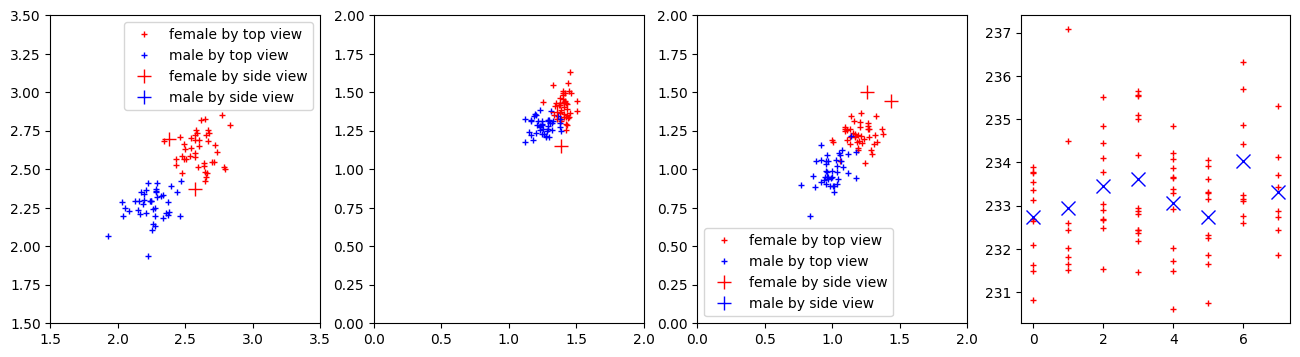

In [7]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
sex_f = genders_status==0
sex_m = genders_status==1
fig = 0
size_lim = [1.5,3.5]
axs[fig].plot(d_f_ht_tracked[sex_f,0], d_f_ht_tracked[sex_f,1], '+r',ms = 5, label = 'female by top view')
axs[fig].plot(d_f_ht_tracked[sex_m,0], d_f_ht_tracked[sex_m,1], '+b',ms = 5, label = 'male by top view')
axs[fig].set_xlim(size_lim);axs[fig].set_ylim(size_lim)

fig = 0
axs[fig].plot(d_w_ht_tracked[sex_f,0], d_w_ht_tracked[sex_f,1], '+r',ms = 10, label = 'female by side view')
axs[fig].plot(d_w_ht_tracked[sex_m,0], d_w_ht_tracked[sex_m,1], '+b',ms = 10, label = 'male by side view')
axs[fig].set_xlim(size_lim);axs[fig].set_ylim(size_lim)
axs[fig].legend()



fig = 1
size_lim = [0,2]
axs[fig].plot(d_f_hc_tracked[sex_f,0], d_f_hc_tracked[sex_f,1], '+r',ms = 5, label = 'female by top view')
axs[fig].plot(d_f_hc_tracked[sex_m,0], d_f_hc_tracked[sex_m,1], '+b',ms = 5, label = 'male by top view')
axs[fig].set_xlim(size_lim);axs[fig].set_ylim(size_lim)

fig = 1
axs[fig].plot(d_w_hc_tracked[sex_f,0], d_w_hc_tracked[sex_f,1], '+r',ms = 10, label = 'female by side view')
axs[fig].plot(d_w_hc_tracked[sex_m,0], d_w_hc_tracked[sex_m,1], '+b',ms = 10, label = 'male by side view')
axs[fig].set_xlim(size_lim);axs[fig].set_ylim(size_lim)
# axs[fig].legend()




fig = 2
size_lim = [0,2]
axs[fig].plot(d_f_ct_tracked[sex_f,0], d_f_ct_tracked[sex_f,1], '+r',ms = 5, label = 'female by top view')
axs[fig].plot(d_f_ct_tracked[sex_m,0], d_f_ct_tracked[sex_m,1], '+b',ms = 5, label = 'male by top view')
axs[fig].set_xlim(size_lim);axs[fig].set_ylim(size_lim)

fig = 2
axs[fig].plot(d_w_ct_tracked[sex_f,0], d_w_ct_tracked[sex_f,1], '+r',ms = 10, label = 'female by side view')
axs[fig].plot(d_w_ct_tracked[sex_m,0], d_w_ct_tracked[sex_m,1], '+b',ms = 10, label = 'male by side view')
axs[fig].set_xlim(size_lim);axs[fig].set_ylim(size_lim)
axs[fig].legend()



fig = 3
size_lim = [0,2]
for i in range(num_file):
    axs[fig].plot(np.arange(8), radius_well[i,:], '+r',ms = 5)
axs[fig].plot(np.arange(8), np.nanmean(radius_well,axis=0), 'xb',ms = 10)
# axs[fig].plot(d_f_ct_tracked[sex_m,0], d_f_ct_tracked[sex_m,1], '+b',ms = 5, label = 'male by top view')
# axs[fig].set_xlim(size_lim);axs[fig].set_ylim(size_lim)




(2, 126000)
(2, 126000)
(2, 126000)
(2, 126000)
(2, 126000)


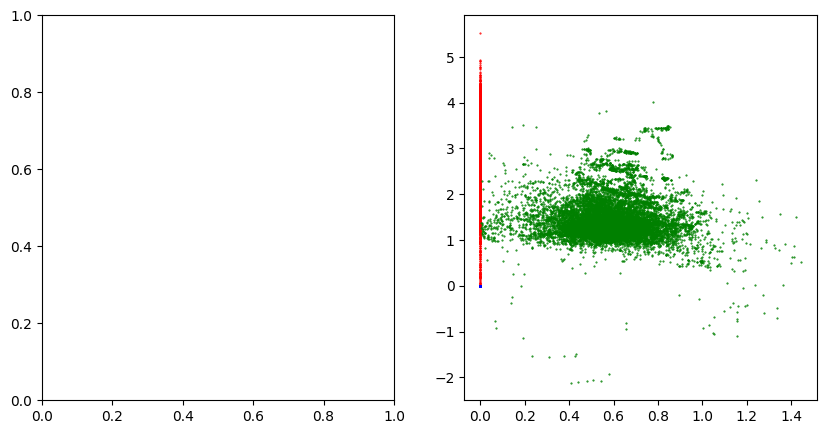

In [7]:
np.set_printoptions(precision=2)
filter_status = '_filtered'
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
d_f_ht_tracked   = np.zeros((num_exp,2))
ms = 1
thr_cf = 0.95
ii = 0
# for i in range(num_file):
for i in range(1):
    experiment = experiments_mscore[fileloc_set[i]]
    sexes        = experiment['sex']
    genotypes   = experiment['genotype']
    experiment_type = experiment['events type']
    events = experiment['events']
    experiment_index = experiments_index[i]
    arena_circle= experiment['arena circle']
    for j in range(num_well):

        sex = sexes[j]
        genotype = genotypes[j]
        
        if sex != -1:
            event_ts   = events[j]
            event_type = experiment_type[j]
            well_arena = arena_circle[j]
#             circle = crop_h[ii,:]
            circle = (np.mean(well_arena, axis = 0))
            d_xy = [576/2, 576/2]-circle[0:2]-48

            parameter_mm2p = (17.4625/circle[2]/2)
            n_event = len(event_ts)
            well = 'v_'+experiment_index+'_'+videofile_set[j]
            

            hfile_wall = h5_dir+'/'+well+scorer_wall+'_el'+filter_status+'.h5'
            my_file_wall = Path(hfile_wall)
            hfile_floor = h5_dir+'/'+well+scorer_floor+'_el'+filter_status+'.h5'
            my_file_floor = Path(hfile_floor)
            hfile_cross = h5_dir+'/'+well+scorer_cross+'_el'+filter_status+'.h5'
            my_file_cross = Path(hfile_cross)

            wall_floor = my_file_wall.is_file() and my_file_floor.is_file()
            wall_floor_cross = wall_floor and my_file_cross.is_file()
            if wall_floor_cross:
                
                Dataframe_floor = pd.read_hdf(os.path.join(hfile_floor))
                Dataframe_wall  = pd.read_hdf(os.path.join(hfile_wall))
                Dataframe_cross = pd.read_hdf(os.path.join(hfile_cross))
                
                loc_floor, conf_floor = nly.read_loc(Dataframe_floor, scorer_floor, animalID, bodyparts_floor)
                loc_wall,  conf_wall  = nly.read_loc(Dataframe_wall,  scorer_wall,  animalID, bodyparts_wall)
                loc_cross, conf_cross = nly.read_loc(Dataframe_cross, scorer_cross, animalID, bodyparts_cross)

                fly_tracker_f = nly.tracking_analysis_or_cf(loc_floor,conf_floor,thr_cf)
                fly_tracker_f_n = np.zeros((2,numBP_floor,2,frame_n))==1
                fly_tracker_f_n[:,:,0,:] = ~fly_tracker_f
                fly_tracker_f_n[:,:,1,:] = ~fly_tracker_f
                loc_floor[fly_tracker_f_n] = np.NaN
                fly_tracker_f_and = nly.tracking_analysis_and(loc_floor)
                fly_tracker_f_or  = nly.tracking_analysis_and(loc_floor)
#                 fly_tracker_f_bp_e  = nly.tracking_analysis_eql(loc_floor, 1, 1)
                well_tracker_f_non = ~ np.logical_or(fly_tracker_f_or[0,:], fly_tracker_f_or[1,:])
                well_tracker_floor = np.logical_and(fly_tracker_f_and[0,:], fly_tracker_f_and[1,:])
                
                f1_and_f2_or_tracker_f = np.logical_and(fly_tracker_f_and[0,:],~fly_tracker_f_or[1,:])
                f1_or_f2_and_tracker_f = np.logical_and(~fly_tracker_f_or[0,:],fly_tracker_f_and[1,:])
                
                
                fly_tracker_w = nly.tracking_analysis_or_cf(loc_wall, conf_wall,thr_cf)
                fly_tracker_w_n = np.zeros((2,numBP_wall,2,frame_n))==1
                fly_tracker_w_n[:,:,0,:] = ~fly_tracker_w
                fly_tracker_w_n[:,:,1,:] = ~fly_tracker_w
                loc_wall[fly_tracker_w_n]  = np.NaN
                fly_tracker_w_and  = nly.tracking_analysis_and(loc_wall)
                fly_tracker_w_or  = nly.tracking_analysis_or(loc_wall)
                
#                 fly_tracker_w_bp_e  = nly.tracking_analysis_eql(loc_wall, 1, 1)
                well_tracker_w_non = ~ np.logical_or(fly_tracker_w_or[0,:], fly_tracker_w_or[1,:])
                well_tracker_wall = np.logical_and(fly_tracker_w_and[0,:], fly_tracker_w_and[1,:])                
                
                f1_and_f2_or_tracker_w = np.logical_and(fly_tracker_w_and[0,:],~fly_tracker_w_or[1,:])
                f1_or_f2_and_tracker_w = np.logical_and(~fly_tracker_w_or[0,:],fly_tracker_w_and[1,:])
                
                
                fly_tracker_c = nly.tracking_analysis_or_cf(loc_cross,conf_cross,thr_cf)
                fly_tracker_c_n = np.zeros((2,4,2,frame_n))==1
                fly_tracker_c_n[:,:,0,:] = ~fly_tracker_c
                fly_tracker_c_n[:,:,1,:] = ~fly_tracker_c
                loc_cross[fly_tracker_c_n]  = np.NaN
                

                loc_temp_cross          = np.zeros((2,1,2,frame_n))
                loc_temp_cross[:,:,:,:] = np.NaN
                loc_temp_cross[:,0,:,:] = np.mean(loc_cross, axis=1)
                
                fly_tracker_c = np.sum(fly_tracker_c,axis=1)==4
                
                print(fly_tracker_c.shape)
                well_tracker_c_non = ~ np.logical_or(fly_tracker_c[0,:], fly_tracker_c[1,:])
                
                f1_and_f2_or_tracker_w_nonc = np.logical_and(well_tracker_c_non,f1_and_f2_or_tracker_w)
                f1_and_f2_or_tracker_w_nonc_nonf = np.logical_and(well_tracker_f_non,f1_and_f2_or_tracker_w_nonc)
                f1_or_f2_and_tracker_w_nonc = np.logical_and(well_tracker_c_non,f1_or_f2_and_tracker_w)
                
                
                
                loc_f_h = loc_wall[0,0,:,:]
                loc_f_c = loc_wall[0,1,:,:]
                loc_f_t = loc_wall[0,2,:,:]

                p_h_w = loc_wall[0,0,:,f1_and_f2_or_tracker_w_nonc_nonf].T
                p_t_w = loc_wall[0,2,:,f1_and_f2_or_tracker_w_nonc_nonf].T
                p_c_w = loc_wall[0,1,:,f1_and_f2_or_tracker_w_nonc_nonf].T

                p_h_w_new = tkr_dec.convert_to_new_coords(p_t_w, p_h_w, p_h_w)*parameter_mm2p
                p_t_w_new = tkr_dec.convert_to_new_coords(p_t_w, p_h_w, p_t_w)*parameter_mm2p
                p_c_w_new = tkr_dec.convert_to_new_coords(p_t_w, p_h_w, p_c_w)*parameter_mm2p
                p_c_w_new[0,:] = np.abs(p_c_w_new[0,:])
                
                axs_i = 1
                axs[axs_i].plot(p_h_w_new[0,:],p_h_w_new[1,:],'r.', ms = ms, label = 'head',)
                axs[axs_i].plot(p_t_w_new[0,:],p_t_w_new[1,:],'b.', ms = ms, label = 'tail',)
                axs[axs_i].plot(p_c_w_new[0,:],p_c_w_new[1,:],'g.', ms = ms, label = 'wall center',)        
                
        

            else:
                print('no h files')
            ii = ii+1
            


# filter tracking data by body size

In [49]:

ii = 0
for i in range(num_file):
#     for i in range(5):
    experiment = experiments_mscore[fileloc_set[i]]
    sexes        = experiment['sex']
    genotypes   = experiment['genotype']
    experiment_type = experiment['events type']
    events = experiment['events']
    experiment_index = experiments_index[i]

    for j in range(num_well):
#         for j in range(1):
        sex = sexes[j]
        genotype = genotypes[j]

        if sex != -1:
            event_ts   = events[j]
            event_type = experiment_type[j]

            circle = crop_h[ii,:]
            d_xy = [576/2, 576/2]-circle[0:2]-48

            parameter_mm2p = (17.4625/circle[2]/2)
            n_event = len(event_ts)
            well = 'v_'+experiment_index+'_'+videofile_set[j]
            

            hfile_wall = h5_dir+'/'+well+scorer_wall+'_el'+filter_status+'.h5'
            my_file_wall = Path(hfile_wall)
            hfile_floor = h5_dir+'/'+well+scorer_floor+'_el'+filter_status+'.h5'
            my_file_floor = Path(hfile_floor)
            hfile_cross = h5_dir+'/'+well+scorer_cross+'_el'+filter_status+'.h5'
            my_file_cross = Path(hfile_cross)

            wall_floor = my_file_wall.is_file() and my_file_floor.is_file()
            wall_floor_cross = wall_floor and my_file_cross.is_file()
            if wall_floor_cross:
                
                Dataframe_floor = pd.read_hdf(os.path.join(hfile_floor))
                Dataframe_wall  = pd.read_hdf(os.path.join(hfile_wall))
                Dataframe_cross = pd.read_hdf(os.path.join(hfile_cross))
                
                loc_floor, conf_floor = nly.read_loc(Dataframe_floor, scorer_floor, animalID, bodyparts_floor)
                loc_wall,  conf_wall  = nly.read_loc(Dataframe_wall,  scorer_wall,  animalID, bodyparts_wall)
                loc_cross, conf_cross = nly.read_loc(Dataframe_cross, scorer_cross, animalID, bodyparts_cross)
                
                prep_time = np.zeros(frame_n)>0
                prep_time[0:17000] = True
                
                fly_tracker_f = nly.tracking_analysis_or_cf(loc_floor,conf_floor,thr_cf)
                fly_tracker_f_n = np.zeros((2,numBP_floor,2,frame_n))==1
                fly_tracker_f_n[:,:,0,:] = ~fly_tracker_f
                fly_tracker_f_n[:,:,1,:] = ~fly_tracker_f
                loc_floor[fly_tracker_f_n] = np.NaN
                loc_floor[:,:,:,prep_time] = np.NaN

                fly_tracker_c = nly.tracking_analysis_or_cf(loc_cross,conf_cross,thr_cf)
                fly_tracker_c_n = np.zeros((2,4,2,frame_n))==1
                fly_tracker_c_n[:,:,0,:] = ~fly_tracker_c
                fly_tracker_c_n[:,:,1,:] = ~fly_tracker_c
                loc_cross[fly_tracker_c_n]  = np.NaN
                loc_cross[:,:,:,prep_time] = np.NaN
                loc_temp_cross          = np.zeros((2,1,2,frame_n))
                loc_temp_cross[:,0,:,:] = np.mean(loc_cross, axis=1)
                conf_temp_cross = np.zeros((2,1,frame_n))
                conf_temp_cross[:,0,:] = np.mean(conf_cross, axis=1)
                
                fly_tracker_cross = np.sum(fly_tracker_c,axis=1) >=3
                fly_tracker_w_n_c = np.zeros((2,numBP_wall,2,frame_n))==1
                for i_bp in range(numBP_wall):
                    fly_tracker_w_n_c[:,i_bp,0,:] = fly_tracker_cross
                    fly_tracker_w_n_c[:,i_bp,1,:] = fly_tracker_cross
                    
                fly_tracker_w = nly.tracking_analysis_or_cf(loc_wall, conf_wall,thr_cf)
                fly_tracker_w_n = np.zeros((2,numBP_wall,2,frame_n))==1
                fly_tracker_w_n[:,:,0,:] = ~fly_tracker_w
                fly_tracker_w_n[:,:,1,:] = ~fly_tracker_w
                loc_wall[fly_tracker_w_n]   = np.NaN
                loc_wall[fly_tracker_w_n_c] = np.NaN # remove
                loc_wall[:,:,:,prep_time]   = np.NaN
                
                fly_tracker_w_or  = nly.tracking_analysis_or(loc_wall)
                well_tracker_w_n  = ~np.logical_or(fly_tracker_w_or[0,:],fly_tracker_w_or[1,:])
                fly_tracker_w_and = nly.tracking_analysis_and(loc_wall)
                
                fly_tracker_w_only_1f = np.logical_or(fly_tracker_w_only_f1, fly_tracker_w_only_f2)
                
                fly_tracker_f_or  = nly.tracking_analysis_or(loc_floor)
                well_tracker_f_n  = ~np.logical_or(fly_tracker_f_or[0,:],fly_tracker_f_or[1,:])
                fly_tracker_f_and = nly.tracking_analysis_and(loc_floor)
                
                fly_tracker_c_or  = nly.tracking_analysis_and(loc_cross)
                well_tracker_c_n  = ~np.logical_or(fly_tracker_c_or[0,:],fly_tracker_c_or[1,:])
                
                well_tracker_n_cf = np.logical_and(well_tracker_f_n, well_tracker_c_n)
                
                
                fly_tracker_w_only_f1 = np.logical_and(fly_tracker_w_and[0,:],~fly_tracker_w_or[1,:])
                fly_tracker_w_only_f2 = np.logical_and(fly_tracker_w_and[1,:],~fly_tracker_w_or[0,:])
                
                fly_tracker_w_only_f1_n_cf = np.logical_and(fly_tracker_w_only_f1, well_tracker_n_cf)
                fly_tracker_w_only_f2_n_cf = np.logical_and(fly_tracker_w_only_f2, well_tracker_n_cf)

                well_tracker_w_only_1f_n_cf = np.logical_or(fly_tracker_w_only_f1_n_cf,fly_tracker_w_only_f2_n_cf)
                well_tracker_w_only_1f = np.logical_or(fly_tracker_w_only_f1,     fly_tracker_w_only_f2)
                print(well, np.sum(well_tracker_w_only_1f), 
#                       np.sum(fly_tracker_w_only_f1_n_cf),
#                       np.sum(fly_tracker_w_only_f2_n_cf),
                     )
                idx_frames = np.arange(frame_n)
                
                d_HT_w = np.squeeze(np.sqrt(np.sum(np.square(np.diff(loc_wall[:,[0,2],:,:],axis=1)),axis=2)))


#                 print(d_HT_w_f1.shape, np.diff(loc_wall[:,[0,2],:,:],axis=1).shape)
#                 np.max(d_f_ht_tracked[ii,:])*1.5
                
#                 loc_wall = fly_tracker_w_only_f1_n_cf[]
                
#                 idx_frames_w_f1 = idx_frames[fly_tracker_w_only_f1_n_cf]
# #                 
#                 for idx_i in idx_frames_w_f1:
                    
                
                
                
                idx_frames_X = idx_frames[well_tracker_w_only_1f_n_cf]

                
                
                
                np.random.shuffle(idx_frames_X)
                
                video = output_fileloc +converted_folder+fileloc_set[i]+'well_'+videofile_set[j]+'_ts.mp4'
                cap = cv2.VideoCapture(video)
                
                i_idx = 0
                for idx_i in idx_frames_X:
                    loc_f_i = loc_floor[:,:,:,idx_i]
                    loc_w_i = loc_wall[:,:,:,idx_i]
                    loc_c_i = loc_temp_cross[:,:,:,idx_i]

                    cf_f_i = conf_floor[:,:,idx_i]
                    cf_w_i = conf_wall [:,:,idx_i]
                    cf_c_i = conf_temp_cross[:,0,idx_i]
                    image = (output_fileloc + cropped_recording_folder +'/R72/Test/'+well+'_'+format(idx_i,'06d')+'_'+str(segment[ii,0]))
                    tkr_dec.save_image_fwc(cap, loc_f_i, loc_w_i, loc_c_i, 
                                         cf_f_i,  cf_w_i,  cf_c_i, 
                                   video, idx_i, image, d_xy, bodyparts_floor)
                    
                    
                    i_idx += 1
                    if i_idx == 5:
                        break
                ii += 1

v_05_08_24_exp1_A1 31335
v_05_08_24_exp1_B1 34516
v_05_08_24_exp1_D1 37212
v_05_08_24_exp1_A2 42579
v_05_08_24_exp1_B2 26512
v_05_08_24_exp2_C1 28717
v_05_08_24_exp2_D1 48371
v_05_08_24_exp2_A2 36626
v_05_08_24_exp2_B2 40251
v_05_08_24_exp2_D2 40427
v_05_09_24_exp1_A1 32814
v_05_09_24_exp1_C1 38824
v_05_09_24_exp1_D1 46951
v_05_09_24_exp1_A2 35277
v_05_09_24_exp1_B2 34869
v_05_09_24_exp1_C2 41453
v_05_09_24_exp1_D2 28515
v_05_09_24_exp2_B1 39204
v_05_09_24_exp2_C1 37290
v_05_09_24_exp2_D1 38277
v_05_09_24_exp2_A2 42425
v_05_13_24_exp1_A1 35361
v_05_13_24_exp1_D1 32825
v_05_13_24_exp1_A2 38468
v_05_13_24_exp1_B2 33735
v_05_13_24_exp1_D2 20880
v_05_13_24_exp2_B1 16565
v_05_13_24_exp2_C1 39940
v_05_13_24_exp2_D1 47122
v_05_13_24_exp2_C2 30975
v_05_13_24_exp3_A1 37826
v_05_13_24_exp3_B1 27789
v_05_13_24_exp3_C1 36694
v_05_13_24_exp3_D1 38348
v_05_15_24_exp1_A1 45652
v_05_15_24_exp1_B1 41432
v_05_15_24_exp1_C1 43173
v_05_15_24_exp1_D1 37119
v_05_15_24_exp1_A2 39592
v_05_15_24_exp1_B2 38031


In [6]:
filter_status = '_filtered'
ii = 0
for i in range(num_file):
# for i in [2]:
# for i in range(1):
    experiment = experiments_mscore[fileloc_set[i]]
    sexes        = experiment['sex']
    genotypes   = experiment['genotype']
    experiment_type = experiment['events type']
    events = experiment['events']
    arena_circle = experiment['arena circle']
    experiment_index = experiments_index[i]
    well_coordinate = {}
    for j in range(num_well):
#     for j in range(1):
#     for i in [0]:
        sex = sexes[j]
        genotype = genotypes[j]
        
        if sex != -1:
            event_ts   = events[j]
            event_type = experiment_type[j]

            well_arena = arena_circle[j]
            circle = np.mean(well_arena, axis = 0)
            d_xy = [576/2, 576/2]-circle[0:2]-48

            
            parameter_mm2p = (17.4625/circle[2]/2)
            
            n_event = len(event_ts)
        
            well = 'v_'+experiment_index+'_'+videofile_set[j]
            
            hfile_wall = h5_dir+'/'+well+scorer_wall+'_el'+filter_status+'.h5'
            my_file_wall = Path(hfile_wall)
            hfile_floor = h5_dir+'/'+well+scorer_floor+'_el'+filter_status+'.h5'
            my_file_floor = Path(hfile_floor)
            hfile_cross = h5_dir+'/'+well+scorer_cross+'_el'+filter_status+'.h5'
            my_file_cross = Path(hfile_cross)
            
            wall_floor = my_file_wall.is_file() and my_file_floor.is_file()
            wall_floor_cross = wall_floor and my_file_cross.is_file()
            if wall_floor_cross:
                print(well)#, np.sum(well_tracker_c_off_xor), np.sum(well_tracker_c_off_and))

                npz_file_name = h5_dir+'/'+well+'_el'+filter_status+'.npz'
                # Access the loaded arrays
                loaded_data = np.load(npz_file_name)
                loc_temp          = loaded_data['loc_temp']
                fly_tracker_temp  = loaded_data['fly_tracker_temp']
                well_tracker_temp = loaded_data['well_tracker_temp']
                well_done = nly.tracking_analysis(fly_tracker_temp)

                Dataframe_floor = pd.read_hdf(os.path.join(hfile_floor))
                Dataframe_wall  = pd.read_hdf(os.path.join(hfile_wall))
                Dataframe_cross = pd.read_hdf(os.path.join(hfile_cross))
                
                loc_floor, conf_floor = nly.read_loc(Dataframe_floor, scorer_floor, animalID, bodyparts_floor)
                loc_wall,  conf_wall  = nly.read_loc(Dataframe_wall,  scorer_wall,  animalID, bodyparts_wall)
                loc_cross, conf_cross = nly.read_loc(Dataframe_cross, scorer_cross, animalID, bodyparts_cross)
                
                prep_time = np.zeros(frame_n)>0
#                 prep_time[0:7000] = True
                thr_cf = 0.9
                fly_tracker_f = nly.tracking_analysis_or_cf(loc_floor,conf_floor,thr_cf)
                fly_tracker_f_n = np.zeros((2,numBP_floor,2,frame_n))==1
                fly_tracker_f_n[:,:,0,:] = ~fly_tracker_f
                fly_tracker_f_n[:,:,1,:] = ~fly_tracker_f
                loc_floor[fly_tracker_f_n] = np.NaN
                loc_floor[:,:,:,prep_time] = np.NaN

                fly_tracker_c = nly.tracking_analysis_or_cf(loc_cross,conf_cross,thr_cf)
                fly_tracker_c_n = np.zeros((2,4,2,frame_n))==1
                fly_tracker_c_n[:,:,0,:] = ~fly_tracker_c
                fly_tracker_c_n[:,:,1,:] = ~fly_tracker_c
                loc_cross[fly_tracker_c_n]  = np.NaN
                loc_cross[:,:,:,prep_time] = np.NaN
                loc_temp_cross          = np.zeros((2,1,2,frame_n))
                loc_temp_cross[:,0,:,:] = np.nanmean(loc_cross, axis=1)
                conf_temp_cross = np.zeros((2,1,frame_n))
                conf_temp_cross[:,0,:] = np.mean(conf_cross, axis=1)
#                 fly_tracker_cross = np.sum(fly_tracker_c,axis=1) ==4
#                 fly_tracker_w_n_c = np.zeros((2,numBP_wall,2,frame_n))==1
#                 for i_bp in range(numBP_wall):
#                     fly_tracker_w_n_c[:,i_bp,0,:] = fly_tracker_cross
#                     fly_tracker_w_n_c[:,i_bp,1,:] = fly_tracker_cross
                    
                fly_tracker_w = nly.tracking_analysis_or_cf(loc_wall, conf_wall,thr_cf)
                fly_tracker_w_n = np.zeros((2,numBP_wall,2,frame_n))==1
                fly_tracker_w_n[:,:,0,:] = ~fly_tracker_w
                fly_tracker_w_n[:,:,1,:] = ~fly_tracker_w
                loc_wall[fly_tracker_w_n]   = np.NaN
#                 loc_wall[fly_tracker_w_n_c] = np.NaN
                loc_wall[:,:,:,prep_time]   = np.NaN
                
#                 fly_tracker_temp_or  = nly.tracking_analysis_or(loc_temp)
#                 fly_tracker_temp_and = nly.tracking_analysis_and(loc_temp)
#                 fly_tracker_temp_only_f = np.zeros((2,frame_n))>0
#                 fly_tracker_temp_only_f[0,:] = np.logical_and(fly_tracker_temp_and[0,:],~fly_tracker_temp_or[1,:])
#                 fly_tracker_temp_only_f[1,:] = np.logical_and(fly_tracker_temp_and[1,:],~fly_tracker_temp_or[0,:])
#                 fly_tracker_temp_hc_ht = np.zeros((2,frame_n))>0
#                 fly_tracker_temp_ct_ht = np.zeros((2,frame_n))>0
                
                idx_outlier_bp = np.zeros(frame_n)>0
                
#                 fly_tracker_and  = nly.tracking_analysis_and(loc_floor)
#                 well_tracker_eql = nly.tracking_analysis_eql(loc_floor, 1, 1)
#                 fly_tracker_f_ht_off = np.zeros((2,frame_n))>0
#                 for i_fly in range(n_ID):
#                     loc_f_h = loc_floor[i_fly,0,:,:]
#                     loc_f_c = loc_floor[i_fly,1,:,:]
#                     loc_f_t = loc_floor[i_fly,2,:,:]
#                     d_f_hc = np.sqrt(np.sum(np.square(loc_f_h-loc_f_c),axis=0))
#                     d_f_ht = np.sqrt(np.sum(np.square(loc_f_h-loc_f_t),axis=0))
#                     d_f_ct = np.sqrt(np.sum(np.square(loc_f_c-loc_f_t),axis=0))
#                     tracker_ht_close = d_f_ht<0.5/parameter_mm2p
#                     tracker_hc_close = d_f_hc<0.5/parameter_mm2p
#                     tracker_ct_close = d_f_ct<0.5/parameter_mm2p
#                     tracker_bp_close = np.logical_or(np.logical_or(tracker_ht_close,tracker_hc_close),tracker_ct_close)
                    
#                     tracker_off_center = ~is_point_between(loc_f_h, loc_f_t, loc_f_c)
#                     tracker_off_center = np.logical_and(tracker_off_center, fly_tracker_and[i_fly,:])
#                     fly_tracker_f_ht_off[i_fly,:] = np.logical_and(tracker_off_center,tracker_bp_close)
                    
#                     loc_floor[i_fly,0,:,fly_tracker_f_ht_off[i_fly,:]] = np.NaN
#                     loc_floor[i_fly,2,:,fly_tracker_f_ht_off[i_fly,:]] = np.NaN
                    
#                     fly_tracker_f[i_fly,0,fly_tracker_f_ht_off[i_fly,:]] = False
#                     fly_tracker_f[i_fly,2,fly_tracker_f_ht_off[i_fly,:]] = False
                
              
                
#                 fly_tracker_and  = nly.tracking_analysis_and(loc_wall)
#                 well_tracker_eql = nly.tracking_analysis_eql(loc_wall, 1, 1)
#                 fly_tracker_w_ht_off = np.zeros((2,frame_n))>0
#                 for i_fly in range(n_ID):
#                     loc_w_h = loc_wall[i_fly,0,:,:]
#                     loc_w_c = loc_wall[i_fly,1,:,:]
#                     loc_w_t = loc_wall[i_fly,2,:,:]
#                     d_w_hc = np.sqrt(np.sum(np.square(loc_w_h-loc_w_c),axis=0))
#                     d_w_ht = np.sqrt(np.sum(np.square(loc_w_h-loc_w_t),axis=0))
#                     d_w_ct = np.sqrt(np.sum(np.square(loc_w_c-loc_w_t),axis=0))
#                     tracker_ht_close = d_w_ht<0.5/parameter_mm2p
#                     tracker_hc_close = d_w_hc<0.5/parameter_mm2p
#                     tracker_ct_close = d_w_ct<0.5/parameter_mm2p
#                     tracker_bp_close = np.logical_or(np.logical_or(tracker_ht_close,tracker_hc_close),tracker_ct_close)
                    
#                     tracker_off_center = ~is_point_between(loc_w_h, loc_w_t, loc_w_c)
#                     tracker_off_center = np.logical_and(tracker_off_center, fly_tracker_and[i_fly,:])
#                     fly_tracker_w_ht_off[i_fly,:] = np.logical_and(tracker_off_center,tracker_bp_close)
                    
#                     loc_wall[i_fly,0,:,fly_tracker_w_ht_off[i_fly,:]] = np.NaN
#                     loc_wall[i_fly,2,:,fly_tracker_w_ht_off[i_fly,:]] = np.NaN
                    
#                     fly_tracker_w[i_fly,0,fly_tracker_w_ht_off[i_fly,:]] = False
#                     fly_tracker_w[i_fly,2,fly_tracker_w_ht_off[i_fly,:]] = False
                
            
#                 print(well,1/parameter_mm2p, np.sum(well_tracker_f_ht_off_xor), np.sum(well_tracker_w_ht_off_xor))
                
                loc_floor, fly_tracker_f, fly_tracker_f_ht_off = nly.filter_loc_ht(
                    loc_floor, fly_tracker_f, 0.5/parameter_mm2p) 
                loc_wall, fly_tracker_w, fly_tracker_w_ht_off = nly.filter_loc_ht(
                    loc_wall, fly_tracker_w, 0.5/parameter_mm2p) 
                
                well_tracker_f_ht_off_xor = np.logical_xor(fly_tracker_f_ht_off[0,:], fly_tracker_f_ht_off[1,:])
#                 well_tracker_f_ht_off_xor = np.logical_and(well_tracker_eql, well_tracker_f_ht_off_xor)
                well_tracker_f_ht_off_and = np.logical_and(fly_tracker_f_ht_off[0,:], fly_tracker_f_ht_off[1,:])
#                 well_tracker_f_ht_off_and = np.logical_and(well_tracker_eql, well_tracker_f_ht_off_and)
                
                well_tracker_w_ht_off_xor = np.logical_xor(fly_tracker_w_ht_off[0,:], fly_tracker_w_ht_off[1,:])
#                 well_tracker_w_ht_off_xor = np.logical_and(well_tracker_eql, well_tracker_w_ht_off_xor)
                well_tracker_w_ht_off_and = np.logical_and(fly_tracker_w_ht_off[0,:], fly_tracker_w_ht_off[1,:])
#                 well_tracker_w_ht_off_and = np.logical_and(well_tracker_eql, well_tracker_w_ht_off_and)
                
                print(well,1/parameter_mm2p, np.sum(well_tracker_f_ht_off_xor), np.sum(well_tracker_w_ht_off_xor))
                
              
#                 video = output_fileloc +converted_folder+fileloc_set[i]+'well_'+videofile_set[j]+'_ts.mp4'
#                 cap = cv2.VideoCapture(video)
#                 idx_frames = np.arange(frame_n)
#                 idx_frames_e = idx_frames[well_tracker_w_ht_off_xor]
#                 np.random.shuffle(idx_frames_e)
                
#                 jj = 0
#                 for idx_i in idx_frames_e:
#                     print(idx_i)
#                     image = (output_fileloc + cropped_recording_folder +'/R72/Test/'+well+'_'+str(i)+'_'+str(j)+'_'+format(idx_i,'06d'))
#                     loc_temp_i         = loc_temp[:,:,:,idx_i]
#                     fly_tracker_temp_i = fly_tracker_temp[:,:,idx_i]
#                     tkr_dec.save_image_temp(cap, loc_temp_i, fly_tracker_temp_i, 
#                                     video, idx_i, image, d_xy, bodyparts_floor)
                    
#                     loc_f_i = loc_floor[:,:,:,idx_i]
#                     loc_w_i = loc_wall[:,:,:,idx_i]
#                     loc_c_i = loc_temp_cross[:,:,:,idx_i]

#                     cf_f_i = conf_floor[:,:,idx_i]
#                     cf_w_i = conf_wall [:,:,idx_i]
#                     cf_c_i = conf_temp_cross[:,0,idx_i]

#                     tkr_dec.save_image_fwc(cap, loc_f_i, loc_w_i, loc_c_i, 
#                                          cf_f_i,  cf_w_i,  cf_c_i, video, idx_i, image, d_xy, bodyparts_floor)
                    
#                     if jj==5:
#                         break
#                     jj += 1
            else:
                print('no h files')
            ii = ii+1

v_05_08_24_exp1_A1
v_05_08_24_exp1_A1 26.617609022682533 0 450
v_05_08_24_exp1_B1
v_05_08_24_exp1_B1 27.071152574434056 2 418
v_05_08_24_exp1_D1
v_05_08_24_exp1_D1 26.71209738641956 7 472
v_05_08_24_exp1_A2
v_05_08_24_exp1_A2 27.039656598822255 1 483
v_05_08_24_exp1_B2
v_05_08_24_exp1_B2 26.409735251599415 0 565
v_05_08_24_exp2_C1
v_05_08_24_exp2_C1 26.680601061286463 0 448
v_05_08_24_exp2_D1
v_05_08_24_exp2_D1 26.605010614961753 5 332
v_05_08_24_exp2_A2
v_05_08_24_exp2_A2 26.843808195295722 17 693
v_05_08_24_exp2_B2
v_05_08_24_exp2_B2 26.926270667194217 18 507
v_05_08_24_exp2_D2
v_05_08_24_exp2_D2 26.554617333599904 14 254
v_05_09_24_exp1_A1
v_05_09_24_exp1_A1 26.888475269271204 8 750
v_05_09_24_exp1_C1
v_05_09_24_exp1_C1 26.907372924542546 1 154
v_05_09_24_exp1_D1
v_05_09_24_exp1_D1 26.730994954310574 1 218
v_05_09_24_exp1_A2
v_05_09_24_exp1_A2 26.749319744178376 17 397
v_05_09_24_exp1_B2
v_05_09_24_exp1_B2 26.806585662776264 4 264
v_05_09_24_exp1_C2
v_05_09_24_exp1_C2 26.83808190052

In [32]:
fly_tracker_and = nly.tracking_analysis_and(loc_floor)

for i_fly in range(n_ID):
    loc_f_h = loc_floor[i_fly,0,:,:]
    loc_f_c = loc_floor[i_fly,1,:,:]
    loc_f_t = loc_floor[i_fly,2,:,:]

    tracker_off_center = is_point_between(loc_f_h, loc_f_t, loc_f_c)
    print(np.sum(tracker_off_center), np.sum(fly_tracker_and[i_fly,:]))


(126000,) (126000,)
40206 40206
(126000,) (126000,)
37793 37793


In [34]:
def is_point_between(a, b, c):
    # Extract coordinates
#     ax, ay = a
    
#     bx, by = b
#     cx, cy = c
    ax = a[0,:];ay = a[1,:]
    bx = b[0,:];by = b[1,:]
    cx = c[0,:];cy = c[1,:]

    # Calculate vector AB (from A to B)
    abx = bx - ax
    aby = by - ay

    # Calculate vector AC (from A to C)
    acx = cx - ax
    acy = cy - ay

    # Compute the dot product of AB and AC
    dot_product = abx * acx + aby * acy

    # Compute the squared length of AB
    length_sq_ab = abx**2 + aby**2
#     # Check if A and B are the same point
#     if length_sq_ab == 0:
#         return (cx == ax) and (cy == ay)

    # Calculate the projection parameter t
    t = dot_product / length_sq_ab
    tracker_off_center = np.logical_and(t <= 1, t >= 0)
    # Determine if the projection of C lies between A and B (inclusive)
    return tracker_off_center

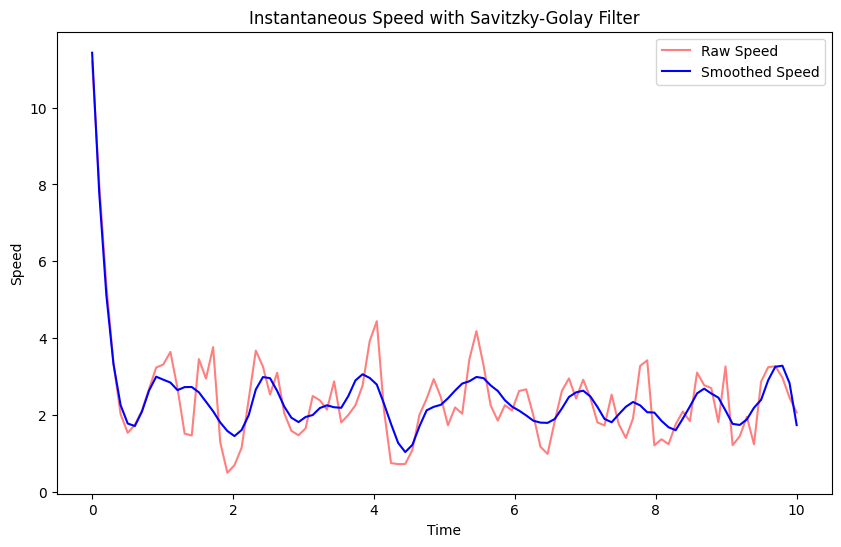

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# Load your data here (replace with your data loading method)
# Assuming data is a NumPy array with columns: time, x, y
# Example data (replace this with your actual data)
t = np.linspace(0, 10, 100)  # Time from 0 to 10s, 100 samples
x = 2 * t + np.random.normal(0, 0.5, size=100)  # Linear motion with noise
y = 3 * t ** 0.5 + np.random.normal(0, 0.3, size=100)  # Non-linear motion with noise
data = np.column_stack((t, x, y))

# Sort data by time (if not already sorted)
data = data[data[:, 0].argsort()]
t, x, y = data[:, 0], data[:, 1], data[:, 2]

# Check if time intervals are uniform
dt = np.diff(t)
if not np.allclose(dt, dt[0], atol=1e-5):
    print("Warning: Time intervals are not uniform. Results may be less accurate.")

# Savitzky-Golay filter parameters
window_length = 11  # Must be odd; adjust based on noise and data density
polyorder = 3       # Polynomial order; typically 2-4

# Apply Savitzky-Golay filter to compute smoothed velocities
delta_t = np.mean(dt)  # Time step (assuming approximately uniform sampling)
vx = savgol_filter(x, window_length, polyorder, deriv=1, delta=delta_t)
vy = savgol_filter(y, window_length, polyorder, deriv=1, delta=delta_t)

# Compute instantaneous speed
speed = np.sqrt(vx ** 2 + vy ** 2)

# Optional: Smooth the speed further if needed
speed_smoothed = savgol_filter(speed, window_length, polyorder)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(t, speed, 'r-', alpha=0.5, label='Raw Speed')
plt.plot(t, speed_smoothed, 'b-', label='Smoothed Speed')
plt.xlabel('Time')
plt.ylabel('Speed')
plt.legend()
plt.title('Instantaneous Speed with Savitzky-Golay Filter')
plt.show()